# Import libraries

In [1]:
import os
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from math import log
from math import floor

from scipy.signal import find_peaks
from scipy.signal import peak_widths

from scipy.integrate import simpson

from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans

from sklearn.metrics import homogeneity_score
from sklearn.metrics import completeness_score
from sklearn.metrics import silhouette_score

from sklearn.metrics.cluster import v_measure_score

In [2]:
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 80)

In [3]:
path_to_save_data = './../data/processed_data'
path_to_save = './../results/03a_features'

# Loading data

## Train & Test data (*smoothed & scaled*)

In [4]:
path_to_ftir_data = './../data/preprocessed_data/ftir_scaled.csv'

In [5]:
data = pd.read_csv(path_to_ftir_data, index_col=0)

print(data.shape)
data.head(3)

(30, 1142)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,1102,1103,1104,1105,1106,1107,1108,1109,1110,1111,1112,1113,1114,1115,1116,1117,1118,1119,1120,1121,1122,1123,1124,1125,1126,1127,1128,1129,1130,1131,1132,1133,1134,1135,1136,1137,1138,1139,1140,1141
wavenumber,1900.766600,1899.802230,1898.837870,1897.873500,1896.909130,1895.944770,1894.980400,1894.016030,1893.051670,1892.087300,1891.122930,1890.158570,1889.194200,1888.229830,1887.265470,1886.301100,1885.336730,1884.372370,1883.408000,1882.44364,1881.479270,1880.514900,1879.550540,1878.586170,1877.621800,1876.657440,1875.693070,1874.728700,1873.764340,1872.799970,1871.835600,1870.871240,1869.906870,1868.942500,1867.978140,1867.013770,1866.049400,1865.085040,1864.120670,1863.156300,...,838.034590,837.070220,836.105860,835.141490,834.177120,833.212760,832.248390,831.284020,830.319660,829.355290,828.390920,827.426560,826.462190,825.497820,824.533460,823.569090,822.604720,821.640360,820.675990,819.711620,818.747260,817.782890,816.818520,815.854160,814.889790,813.925420,812.961060,811.996690,811.032320,810.067960,809.103590,808.139230,807.174860,806.210490,805.246130,804.281760,803.317390,802.353030,801.388660,800.424290
1,0.000494,0.000944,0.001362,0.001750,0.002112,0.002451,0.002770,0.003074,0.003364,0.003646,0.003921,0.004193,0.004467,0.004744,0.005028,0.005324,0.005633,0.005960,0.006308,0.00668,0.007079,0.007509,0.007974,0.008476,0.009019,0.009606,0.010241,0.010927,0.011667,0.012465,0.013324,0.014248,0.015257,0.016362,0.017554,0.018820,0.020172,0.021624,0.023174,0.024816,...,0.065789,0.063890,0.061982,0.060076,0.058172,0.056248,0.054288,0.052317,0.050374,0.048435,0.046505,0.044587,0.042687,0.040807,0.038950,0.037121,0.035323,0.033560,0.031835,0.030152,0.028514,0.026926,0.025390,0.023910,0.022491,0.021135,0.019846,0.018627,0.017483,0.016417,0.015433,0.014533,0.013723,0.013004,0.012382,0.011859,0.011440,0.011127,0.010924,0.010836
2,0.000210,0.000215,0.000213,0.000205,0.000192,0.000175,0.000155,0.000132,0.000109,0.000085,0.000063,0.000042,0.000025,0.000011,0.000003,0.000000,0.000004,0.000017,0.000039,0.00007,0.000113,0.000168,0.000236,0.000318,0.000415,0.000529,0.000660,0.000808,0.000976,0.001165,0.001374,0.001606,0.001952,0.002322,0.002637,0.002887,0.003124,0.003457,0.003980,0.004595,...,0.082794,0.082509,0.082135,0.081668,0.081128,0.080544,0.079944,0.079301,0.078584,0.077938,0.077231,0.076459,0.075622,0.074716,0.073739,0.072690,0.071565,0.070364,0.069083,0.067721,0.066275,0.064743,0.063123,0.061413,0.059610,0.057713,0.055719,0.053626,0.051432,0.049135,0.046732,0.044221,0.041600,0.038868,0.036021,0.033058,0.029976,0.026773,0.023447,0.019997


## Samples description

In [6]:
path_to_samples_description = './../data/preprocessed_data/ftir_description.csv'

In [7]:
samples_description = pd.read_csv(path_to_samples_description, index_col=0)

samples_description.index = samples_description.index.astype(str)

print(samples_description.shape)
samples_description.head(3)

(29, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


# Datasets wrangling

## FTIR data

In [8]:
wavenumber = data.loc['wavenumber']
absorbance = data.loc['1':]

## Samples descriprion

In [9]:
samples_description = samples_description.loc[samples_description['Label'] == 'Train']

print(samples_description.shape)
samples_description.head(3)

(25, 4)


,Description,Type,Class,Label
1,"MFGO, разб. 1:20",$GO$,1,Train
2,"HGO, 0.0116 г в 25 мл H2O",$GO$,1,Train
3,"GO, RusGraphene, 2 г в 1000 мл H2O",$GO$,1,Train


In [10]:
# type_dict = {
#     '$rGO$': '$вОГ$',
#     '$GO$': '$ОГ$',
#     '$GO_{d}$': '$ОГ_{диализ}$',
# }

# samples_description['Type'] = samples_description['Type'].apply(lambda x: type_dict[x])

# print(samples_description.shape)
# samples_description.head(3)

# Feature extraction

## Calculating peaks coordinates

In [11]:
id_wavenumber_peaks_dict = {}
id_spectrum_peaks_dict = {}

for idx in absorbance.index:
    spectrum = absorbance.loc[idx].to_numpy()
    peaks_indexes, _ = find_peaks(spectrum, height=0.1, prominence=0.01)

    spectrum_peaks = [spectrum[index] for index in peaks_indexes]
    wavenumber_peaks = [wavenumber[index] for index in peaks_indexes]

    id_wavenumber_peaks_dict[idx] = wavenumber_peaks
    id_spectrum_peaks_dict[idx] = spectrum_peaks

KeyError: '33'

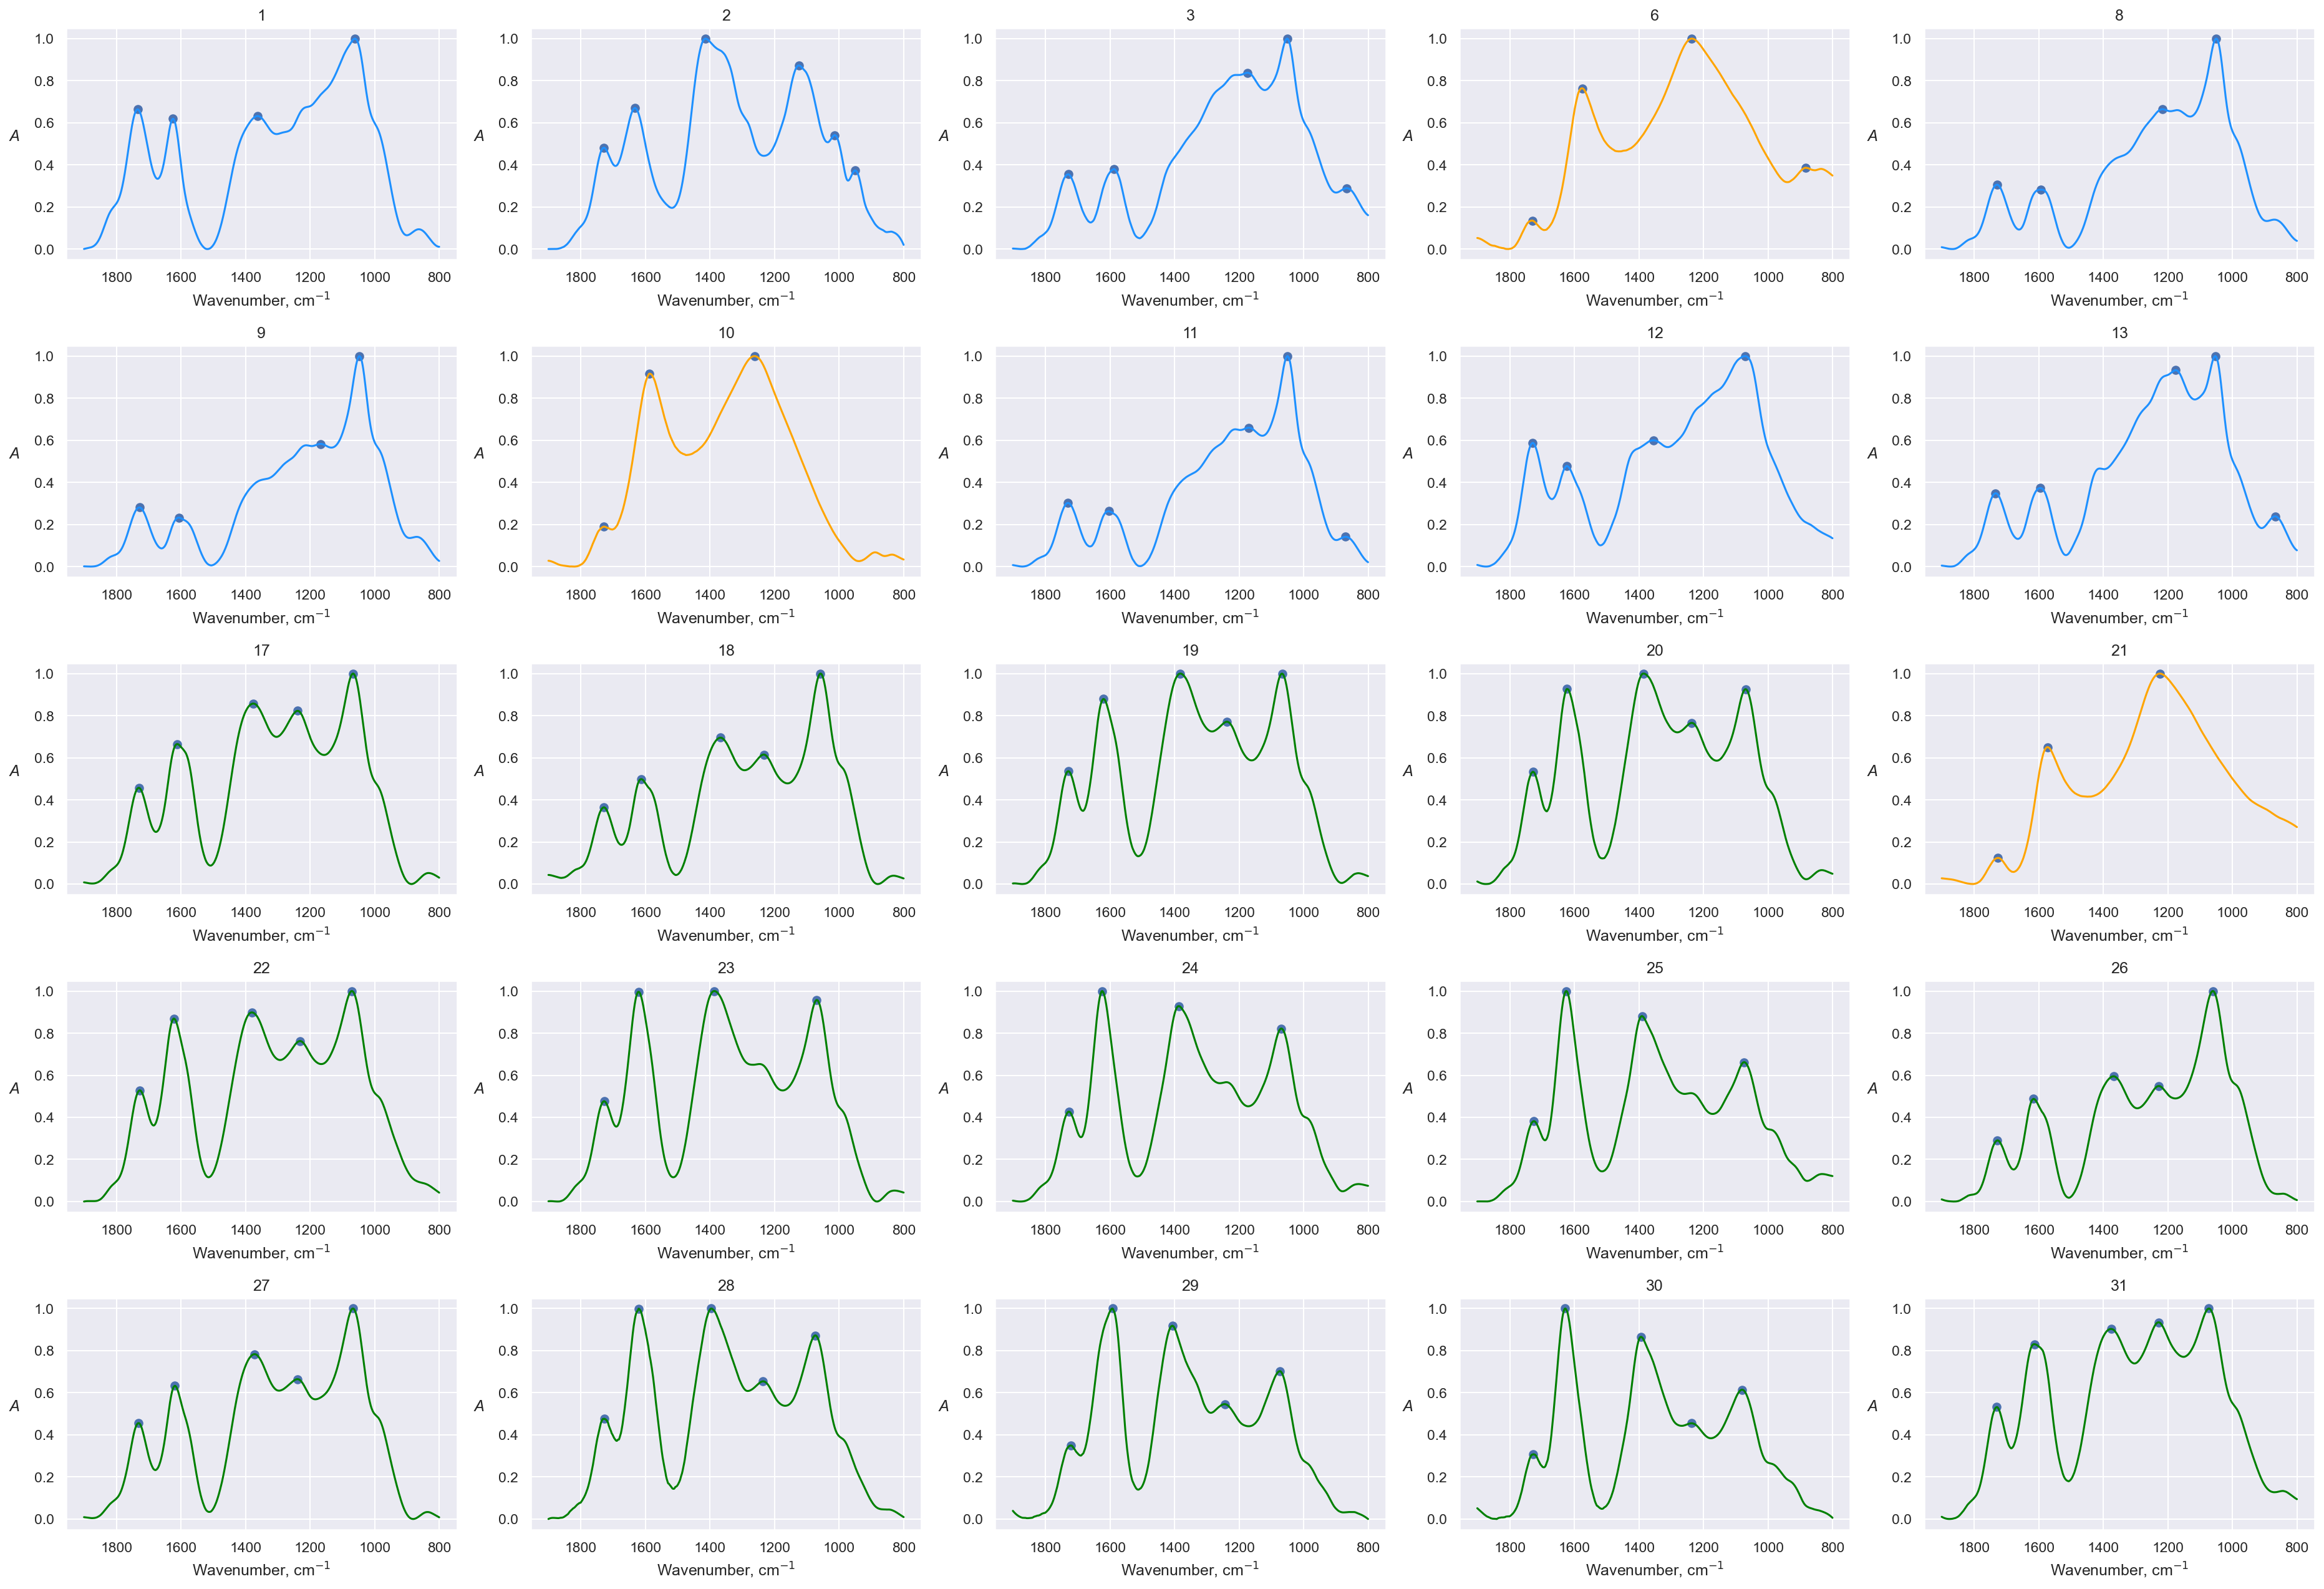

In [12]:
# visualizing spectra and peaks

unique_types = samples_description['Type'].unique()
colors = ['dodgerblue', 'orange', 'green']

type_color = dict(zip(unique_types, colors))

fontstyle = 'italic'
fontsize=12

sns.set_theme()
fig = plt.figure(figsize=(25, 20), dpi=150)

nrows = 6
ncols = 5

for i, idx in enumerate(absorbance.index):
    spectrum = absorbance.loc[idx].to_numpy()
    peaks_wavenumber = id_wavenumber_peaks_dict[idx]
    peaks_spectrum = id_spectrum_peaks_dict[idx]

    type = samples_description.loc[idx]['Type']
    color = type_color[type]

    ax = plt.subplot(nrows, ncols, i+1)

    ax.set_title(idx)
    
    ax.plot(wavenumber, spectrum, color=color, label=type)
    ax.scatter(peaks_wavenumber, peaks_spectrum)

    ax.set_xlabel('Wavenumber, cm$^{-1}$', fontstyle='normal', fontsize=fontsize, labelpad=5)
    ax.set_ylabel('A', fontstyle=fontstyle, fontsize=fontsize, labelpad=15, rotation=0)
    
    ax.invert_xaxis()
        
    plt.tight_layout()

plt.savefig(f'{path_to_save}/spectra_with_peaks.png', dpi=600)

In [ ]:
# set that contain all peaks
all_wavenumber_peaks = []

for i, idx in enumerate(absorbance.index):
    peaks_wavenumber = id_wavenumber_peaks_dict[idx]
    all_wavenumber_peaks.extend(peaks_wavenumber)

all_wavenumber_peaks = sorted(set(all_wavenumber_peaks))

all_wavenumber_peaks_df = pd.DataFrame({'$Wavenumber_{peak}$': all_wavenumber_peaks}).T
all_wavenumber_peaks_df

## Functions for calculating peak area

In [ ]:
def find_width(y, height=0.1, prominence=0.01, rel_height=1):
    peaks, _ = find_peaks(y, height=height, prominence=prominence)
    result = peak_widths(y, peaks, rel_height=rel_height)
    width = result[1:]
    if len(width[0]) == 0:
        pass
    else:
        wavenumber_lst = wavenumber.tolist()
        width = list(width)
        width[1] = [wavenumber_lst[+floor(i)] for i in width[1]]
        width[2] = [wavenumber_lst[+floor(i)] for i in width[2]]
        width = tuple(width)
    return width  # (y, x_min, x_max)

In [ ]:
def integrate_peaks(x, y, height=0.1, prominence=0.01, rel_height=0.5):
    p, _ = find_peaks(y, height=height, prominence=prominence)
    peaks_positions = [x[j] for j in p]
    
    peak_area_dict = {}
    
    x1_lst, x2_lst = find_width(y, height=height, prominence=prominence, rel_height=rel_height)[1:]
    
    for peak_position, x1, x2 in zip(peaks_positions, x1_lst, x2_lst):
        i_start = x.index(x1)
        i_end = x.index(x2)
        y_integrate = y[i_start:i_end+1]
        x_integrate = x[i_start:i_end+1]
        y_rectangle = [y_integrate[0]] * len(y_integrate)
        full_area = abs(simpson(y_integrate, x_integrate))
        rectangle_area = abs(simpson(y_rectangle, x_integrate))
        area = full_area - rectangle_area
        peak_area_dict[peak_position] = area
    return peak_area_dict

## Extracating features

In [ ]:
# calculating total area and intensity
total_intensity = [round(sum(intensity), 4) for intensity in id_spectrum_peaks_dict.values()]
total_area = [sum(integrate_peaks(wavenumber.tolist(), absorbance.loc[idx].tolist()).values()) for idx in absorbance.index]

# calculating intensity and area for band 1620 (c=c)
peak_intensity_cc = [intensities[1] for intensities in id_spectrum_peaks_dict.values()]
peak_area_cc = [list(integrate_peaks(wavenumber.tolist(), absorbance.loc[idx].tolist()).values())[1] for idx in absorbance.index]

# calculating intensity and area for band 1730 (c=o)
peak_intensity_co = [intensities[0] for intensities in id_spectrum_peaks_dict.values()]
peak_area_co = [list(integrate_peaks(wavenumber.tolist(), absorbance.loc[idx].tolist()).values())[0] for idx in absorbance.index]

In [ ]:
base_features_dict = {
    '$ΣI$': total_intensity,
    '$ΣS$': total_area,
    '$I_{1619}$': peak_intensity_cc,
    '$S_{1619}$': peak_area_cc,
    '$I_{1720}$': peak_intensity_co,
    '$S_{1720}$': peak_area_co
}

base_features = pd.DataFrame(base_features_dict, index=data.index[1:])

print(base_features.shape)
base_features.head(3)

# Descriprive statistics of extracted features

In [ ]:
type_color_dict = {
    '$GO$': 'RoyalBlue',
    '$rGO$': 'Goldenrod',
    '$GO_{d}$': 'SeaGreen'
}

## Dataset preparation

*Selecting data for visualization of distribution but only `train` subsample*

In [ ]:
parameters = base_features.columns
train_indexes_lst = samples_description.loc[samples_description['Label'] == 'Train'].index

In [ ]:
vis_data = base_features.copy().loc[train_indexes_lst]
vis_data['Type'] = samples_description.loc[train_indexes_lst]['Type']

print(vis_data.shape)
vis_data.head(3)

## BoxPlot

In [ ]:
fontsize = 16

In [ ]:
sns.set_theme(style="darkgrid")

fig = plt.figure(figsize=(8, 6.60), dpi=600)

nrows = 2
ncols = 3

for i, feature in enumerate(parameters):
    ax = plt.subplot(nrows, ncols, i + 1)

    sns.boxplot(
        data=vis_data,
        x="Type",
        y=feature,
        palette=type_color_dict,
        width=0.4,
        showfliers=False,
        ax=ax
    )

    sns.stripplot(
        data=vis_data,
        x="Type",
        y=feature,
        hue="Type",
        palette=type_color_dict,
        alpha=0.7,
        size=8,
        linewidth=0.5,
        dodge=True,
        ax=ax
    )

    ax.set_ylabel(feature, fontsize=fontsize+2)
    ax.set_xlabel("Sample Type", fontsize=fontsize)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize-2)
    
    if ax.legend_:
        ax.legend_.remove()

plt.tight_layout()

plt.savefig(f'{path_to_save}/sf_boxplot_by_type.png', dpi=600)

plt.show()

## ViolinPlot

In [ ]:
fontsize = 16

In [ ]:
sns.set_theme(style="darkgrid")

fig = plt.figure(figsize=(8, 6.60), dpi=600)

nrows = 2
ncols = 3

for i, feature in enumerate(parameters):
    ax = plt.subplot(nrows, ncols, i + 1)

    sns.violinplot(
        data=vis_data,
        x="Type",
        y=feature,
        hue="Type",
        palette=type_color_dict,
        split=True,  # type of probability distribution visualization
        ax=ax
    )

    ax.set_ylabel(feature, fontsize=fontsize+2)
    ax.set_xlabel("Sample Type", fontsize=fontsize)

    ax.set_xticklabels(ax.get_xticklabels(), fontsize=fontsize-2)

    if ax.legend_:
        ax.legend_.remove()

plt.tight_layout()

plt.savefig(f'{path_to_save}/sf_violinplot_by_type.png', dpi=600)

plt.show()

# Feature engineering

In [ ]:
dict_initial_raw = dict(zip(base_features.columns, ['ΣI', 'ΣS', 'I_{1619}', 'S_{1619}', 'I_{1720}', 'S_{1720}']))

dict_columns = dict(zip(base_features.columns, ['$(ΣI)_{n}$', '$(ΣS)_{n}$', '$I_{1619, n}$', '$S_{1619, n}$', '$I_{1720, n}$', '$S_{1720, n}$']))

engineered_data = base_features.copy().rename(columns=dict_columns)

## Combining features as a *quotient of division*

In [ ]:
for i, feature1 in enumerate(base_features.columns):
    feature1_raw = dict_initial_raw[feature1]
    
    for j, feature2 in enumerate(base_features.columns):
        if j <= i:
            continue
        else:
            feature2_raw = dict_initial_raw[feature2]
            new_feature_name = r'$(\frac{' + feature1_raw + '}{' + feature2_raw + '})_{n}$'
            new_feature_value = base_features[feature1] / base_features[feature2]

            engineered_data[new_feature_name] = new_feature_value

print(engineered_data.shape)
engineered_data.head(3)

## Raising features to power *n* and –*n*

In [ ]:
for feature1 in base_features.columns:
    feature1_raw = dict_initial_raw[feature1]

    new_feature_name = f'$({feature1_raw}^' + '{' + f'{-1}' + '})_{n}$'
    new_feature_value = base_features[feature1] ** (-1)
    engineered_data[new_feature_name] = new_feature_value

    for n in range(2, 6):
        new_feature_name = f'$({feature1_raw}^' + f'{n}' + ')_{n}$'
        new_feature_value = base_features[feature1] ** (n)
        engineered_data[new_feature_name] = new_feature_value

        new_feature_name = f'$({feature1_raw}^' + '{' + f'{-n}' + '})_{n}$'
        new_feature_value = base_features[feature1] ** (-n)
        engineered_data[new_feature_name] = new_feature_value

print(engineered_data.shape)
engineered_data.head(3)

## *Logarithm* of features

In [ ]:
for feature1 in base_features.columns:
    feature1_raw = dict_initial_raw[feature1]

    new_feature_name = f'$(ln|{feature1_raw}|' + ')_{n}$'
    new_feature_value = np.log(np.abs(base_features[feature1]))
    engineered_data[new_feature_name] = new_feature_value

print(engineered_data.shape)
engineered_data.head(3)

*Saving features before scaling*

# Final data transormations

## Splitting data to *train/test*

In [ ]:
train_indexes_lst = samples_description.loc[samples_description['Label'] == 'Train'].index
test_indexes_lst = samples_description.loc[samples_description['Label'] == 'Test'].index

In [ ]:
engineered_data_train = engineered_data.loc[train_indexes_lst]

print(engineered_data_train.shape)
engineered_data_train.head(3)

In [ ]:
engineered_data_test = engineered_data.loc[test_indexes_lst]

print(engineered_data_test.shape)
engineered_data_test.head(3)

## Scaling features (`train`)

In [ ]:
columns = engineered_data_train.columns
indexes = engineered_data_train.index

In [ ]:
scaler = MinMaxScaler()

engineered_data_train_scaled = pd.DataFrame(
    scaler.fit_transform(engineered_data_train), 
    columns=columns, 
    index=indexes
)

print(engineered_data_train_scaled.shape)
engineered_data_train_scaled.head(3)

## Saving processed data

In [ ]:
engineered_data_train.to_csv(f'{path_to_save_data}/ftir_engineered_features_train.csv')
engineered_data_test.to_csv(f'{path_to_save_data}/ftir_engineered_features_test.csv')

In [ ]:
engineered_data_train_scaled.to_csv(f'{path_to_save_data}/ftir_engineered_features_train_scaled.csv')